### В модуле реализовано:
* Создание сетки
* Создание генератора
* Тренировка сети


In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.0 MB/s eta 0:00:00


## Подготовка среды

In [2]:
import os
import pickle
import bz2
import re
import shutil as sh
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import gdown
import nibabel as nib
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

## Чтение и распаковка данных

In [3]:
GDRIVE_ID = '1eCJMpek7oVQO-ip2mPkmxCuJsKGmYPH8'
DATASET_PATH = '/content/data_set'

In [4]:
gdown.download(id=GDRIVE_ID)

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1eCJMpek7oVQO-ip2mPkmxCuJsKGmYPH8 



In [5]:
if os.path.exists(DATASET_PATH): sh.rmtree(DATASET_PATH)
os.makedirs(DATASET_PATH)
sh.unpack_archive('/content/dataset_pickle.zip', DATASET_PATH)

## Функции загрузки данных

In [6]:
def load_folder(path):
  with bz2.BZ2File(f'{path}/input.pickle', 'rb') as f:
    input_data = pickle.load(f)
  with bz2.BZ2File(f'{path}/output.pickle', 'rb') as f:
    output_data = pickle.load(f)

  return input_data, output_data

## Функции для отрисовки изображений

In [7]:
def draw(data):
  ITEM_PER_ROW = 10
  cnt = data.shape[0]
  rows, cols = (cnt)//ITEM_PER_ROW+1, ITEM_PER_ROW
  fig, ax = plt.subplots(rows, cols, figsize=(10, rows))
  for i in range(rows):
    for j in range(cols):
      AX = ax[i, j]
      AX.axis('off')
      if i*ITEM_PER_ROW+j<(cnt):
        AX.imshow(data[i*ITEM_PER_ROW+j], cmap='gray')
  plt.show()

## Чтение списка файлов и показ изображений

Входные данные


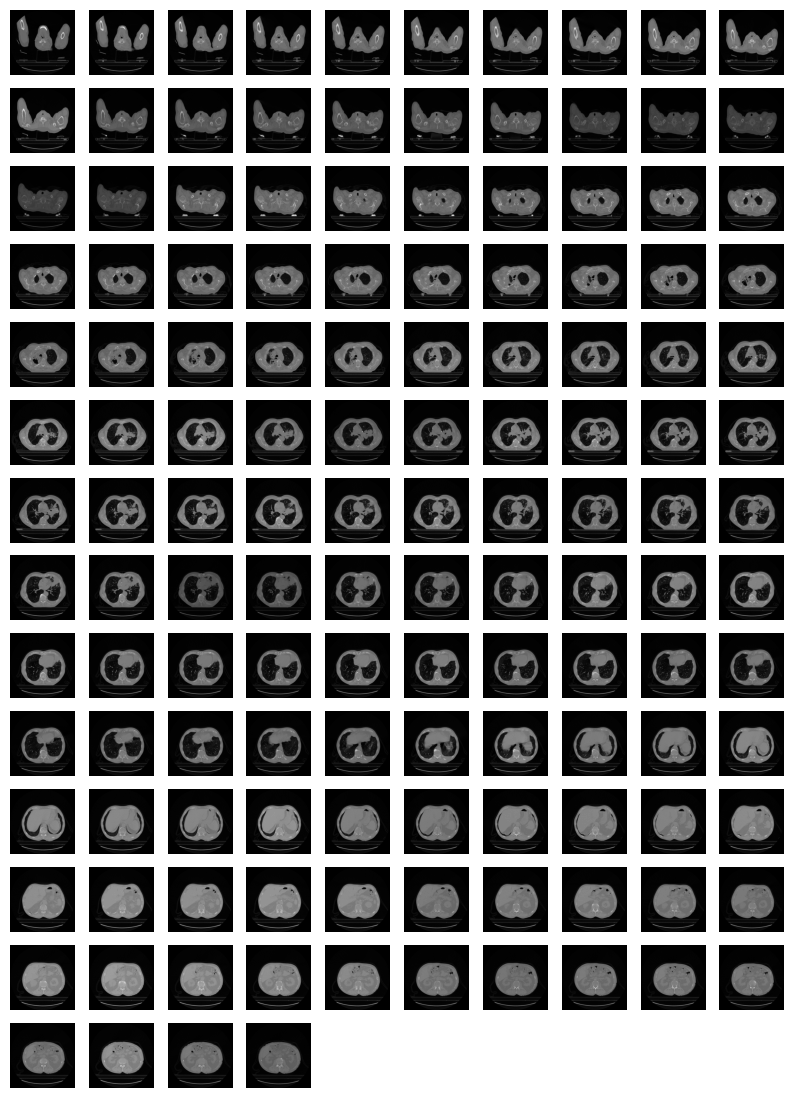

Выходные данные вариант 0 из 4


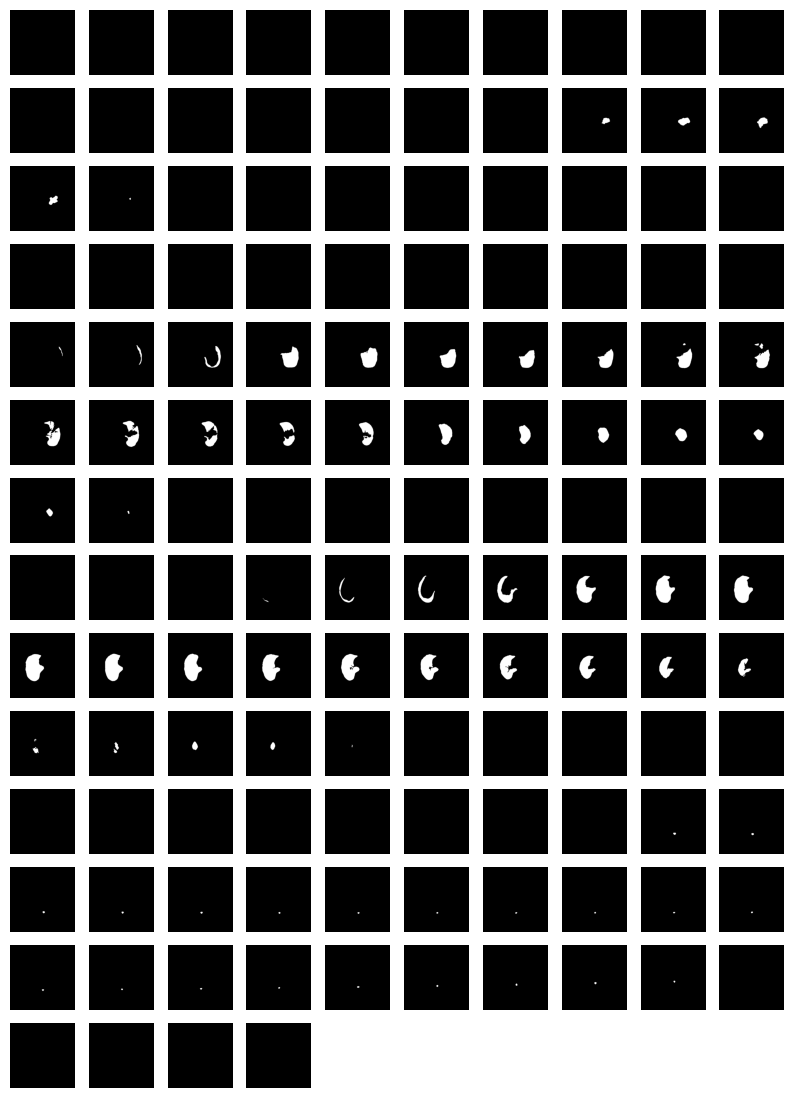

In [8]:
dirs = [f'{DATASET_PATH}/{item}' for item in sorted(os.listdir(f'{DATASET_PATH}'))]
for dir in dirs[:1]:
  input_data, output_data = load_folder(dir)
  # количество выходных копий
  cnt_opt = output_data.shape[0]//input_data.shape[0]
  print('Входные данные')
  draw(input_data)
  # Выбираем из выходного набора нулевой вариант (можно выбрать до cnt_opt-1)
  print(f'Выходные данные вариант 0 из {cnt_opt}')
  draw(output_data[0::cnt_opt])
  # draw(output_data[0])
  # draw(output_data[input_data])

## Создание тренировочного, проверочного и тестового наборов


In [9]:
# Загрузка имен папок со случаями
cases = np.array([f'{DATASET_PATH}/{item}' for item in sorted(os.listdir(f'{DATASET_PATH}'))[:10]])
len_cases = len(cases)

In [10]:
# Загрузка данных и определение мин/max размерности 0 массивов
import sys
min_size = sys.maxsize
max_size = 0
input_data, output_data = [], []
for cs in cases:
  inp_data, out_data = load_folder(cs)
  if inp_data.shape[0]!=0:
    print(cs, out_data.shape[0], inp_data.shape[0])
    input_data.append(inp_data)
    output_data.append(out_data[0::out_data.shape[0]//inp_data.shape[0]])
    min_size = min(inp_data.shape[0], min_size)
    max_size = max(inp_data.shape[0], max_size)
print(min_size, max_size)

/content/data_set/LUNG1-001 536 134
/content/data_set/LUNG1-002 666 111
/content/data_set/LUNG1-003 642 107
/content/data_set/LUNG1-004 570 114
/content/data_set/LUNG1-005 546 91
/content/data_set/LUNG1-006 684 114
/content/data_set/LUNG1-007 774 129
/content/data_set/LUNG1-008 684 114
/content/data_set/LUNG1-009 525 105
/content/data_set/LUNG1-010 546 91
91 134


In [13]:
# Приведение 0 размерности к одному варианту
for i in range(len_cases):
  inp_first = input_data[i][0]
  out_first = output_data[i][0]
  inp_last = input_data[i][input_data[i].shape[0]-1]
  out_last = output_data[i][input_data[i].shape[0]-1]
  inp_temp, out_temp = [], []
  before_items = (max_size-input_data[i].shape[0])//2
  after_items = (max_size-input_data[i].shape[0]) - before_items
  for j in range(before_items):
    inp_temp.append(inp_first)
    out_temp.append(out_first)
  for j in range(input_data[i].shape[0]):
    inp_temp.append(input_data[i][j])
    out_temp.append(output_data[i][j])
  for j in range(after_items):
    inp_temp.append(inp_last)
    out_temp.append(out_last)
  input_data[i] = np.array(inp_temp)
  output_data[i] = np.array(out_temp)

In [14]:
import sys
images = []
masks = []

images = np.array(input_data)
masks = np.array(output_data)

# Разделить данные на тренировочный и тестовый наборы
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Привести данные к необходимому формату.Ресайз изображений и масок до одного размера
image_size = (128, 128, 64)
train_images = np.array([resize(image, image_size, anti_aliasing=True) for image in train_images])
test_images = np.array([resize(image, image_size, anti_aliasing=True) for image in test_images])
train_masks = np.array([resize(mask, image_size, anti_aliasing=True) for mask in train_masks])
test_masks = np.array([resize(mask, image_size, anti_aliasing=True) for mask in test_masks])

In [29]:
#@title Создание модели
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate

def unet_3d(input_size=(256, 256, 64, 1)):
    inputs = Input(input_size)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling3D(size=(2, 2, 2))(conv4)
    up5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=4)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(merge5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling3D(size=(2, 2, 2))(conv5)
    up6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=4)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling3D(size=(2, 2, 2))(conv6)
    up7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=4)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)

    conv8 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])

    return model
# Пример использования модели
input_shape = (128, 128, 64, 1)
num_classes = 1

model = unet_3d(input_shape)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_55 (Conv3D)             (None, 128, 128, 64  896         ['input_4[0][0]']                
                                , 32)                                                             
                                                                                                  
 conv3d_56 (Conv3D)             (None, 128, 128, 64  27680       ['conv3d_55[0][0]']              
                                , 32)                                                       

In [27]:
#@title Компиляция и обучение модели
from keras import backend as K
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [ ]:
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy

model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coefficient])

model.fit(train_images, train_masks, batch_size=4, epochs=10, validation_data=(test_images, test_masks))

In [ ]:
#@title Оценка модели
loss, dice = model.evaluate(test_images, test_masks)
print('Тест loss:', loss)
print('Тест dice коэффициент:', dice)

In [ ]:
#@title Использование модели для предсказаний
image = pydicom.dcmread('/path/to/new/image.dcm').pixel_array
image = np.expand_dims(image, axis=-1)
image = np.expand_dims(image, axis=0)

mask = model.predict(image)